# Fine-tuning a transformer model for sentiment classification

## *Fully Connected Neural Network*

In [2]:
%reload_ext watermark
%watermark -a "postcristiano.pt"

Author: postcristiano.pt



In [8]:
!pip install -q spacy

In [9]:
!pip install -q transformers

In [69]:
# Project dependencies
import os
import math
import nltk
import spacy
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import transformers
from tokenizers import BertWordPieceTokenizer
from tqdm import tqdm
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from tensorflow import keras
from keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer # OLD | from keras.preprocessing.text import Tokenizer
from keras.metrics import Precision, Recall, AUC
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.callbacks import EarlyStopping, LearningRateScheduler, CallbackList, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam # OLD | from tensorflow.keras.optimizers.experimental import Adam


# Disable TensorFlow registration warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
tf.get_logger().setLevel('ERROR')

# Additional configuration to avoid general logging warnings
import logging
logging.getLogger('tensorflow').disabled = True

# Ignore specific warningss
import warnings
warnings.filterwarnings('ignore')

## Load Text Data

In [11]:
# Load train data
train_data_pt = pd.read_csv('samples/train_data.txt', header = None, delimiter = ';')

In [12]:
# Load test data
test_data_pt = pd.read_csv('samples/test_data.txt', header = None, delimiter = ';')

In [13]:
# Adjust columns
train_data_pt = train_data_pt.rename(columns = {0: 'raw_text', 1:'sentiment'})
test_data_pt = test_data_pt.rename(columns = {0: 'raw_text', 1:'sentiment'})

In [14]:
# Shape
train_data_pt.shape

(16000, 2)

In [15]:
# Shape
test_data_pt.shape

(2000, 2)

In [16]:
# Data train sample
train_data_pt.head()

,raw_text,sentiment
0,i am feeling completely overwhelmed i have two...,fear
1,i have the feeling she was amused and delighted,joy
2,i was able to help chai lifeline with your sup...,joy
3,i already feel like i fucked up though because...,anger
4,i still love my so and wish the best for him i...,sadness


In [17]:
# List sentiments in data train
train_data_pt['sentiment'].value_counts()

sentiment
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

In [18]:
# List sentiments in data test
test_data_pt['sentiment'].value_counts()

sentiment
joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: count, dtype: int64

## Pre-processing of Text Data with SpaCy
(https://spacy.io/)

In [19]:
!python -m spacy download en_core_web_md -q

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [20]:
# Load the dictionary
pt_nlp = spacy.load('en_core_web_md')

In [21]:
# Set function 'pt_preprocessing_text' that receives a text as a parameter
def pt_preprocessing_text(text):
    
    # Process the text using the dictionary
    doc = pt_nlp(text)
    
    # Creates a list of lemmas from the tokens, converted to lowercase and without blanks, 
    # excluding words that are stopwords
    tokens = [token.lemma_.lower().strip() for token in doc if not token.is_stop]
    
    # returns the processed tokens as a single string, joining them with spaces
    return ' '.join(tokens)

In [22]:
# Applies function in train data
train_data_pt['processed_text'] = train_data_pt['raw_text'].apply(pt_preprocessing_text)

In [23]:
# Applies function in test data
test_data_pt['processed_text'] = test_data_pt['raw_text'].apply(pt_preprocessing_text)

In [24]:
# Data train sample
test_data_pt.head()

,raw_text,sentiment,processed_text
0,i feel like my only role now would be to tear ...,sadness,feel like role tear sail pessimism discontent
1,i feel just bcoz a fight we get mad to each ot...,anger,feel bcoz fight mad n u wanna publicity n let ...
2,i feel like reds and purples are just so rich ...,joy,feel like red purple rich kind perfect
3,im not sure the feeling of loss will ever go a...,sadness,m sure feeling loss away dull sweet feeling no...
4,i feel like ive gotten to know many of you thr...,joy,feel like ve get know comment email m apprecia...


## Model 1 - Fully Connected Neural Network Architecture

### *Step 1 | Vectorization with TF-IDF*

In [25]:
# Create vectorizer
pt_tfidf = TfidfVectorizer(max_df = 0.95, min_df = 2, stop_words = 'english')

Above creates an instance of TfidfVectorizer from the scikit-learn library, which is a tool used to convert a collection of raw documents into a TF-IDF (Term Frequency-Inverse Document Frequency) feature matrix. TF-IDF is a statistical technique used to quantify the importance of a word in a set of documents, commonly used in natural language processing and information retrieval tasks.

**Parameter max_df=0.95:** This parameter defines the maximum document frequency limit for the terms that will be considered. Here, it is set to 0.95, which means that words that appear in more than 95% of documents will be ignored. This helps eliminate common words that don't contribute much to the meaning of the text.

**Parameter min_df=2:** This parameter establishes the minimum document frequency for the terms. In this case, terms that appear in less than 2 documents will be ignored. This helps filter out rare terms that may only occur in a few samples and are therefore less relevant to the overall analysis.

**stop_words='english'**: This parameter instructs the vectorizer to remove all English stop words from the analysis. Stop words are common words (such as "and", "the", "in") that are often filtered out in natural language processing because they are too frequent and do not carry meaningful information for text analysis.

In [29]:
# Applies vectorizer
# fit_transform only train data sample, because fit_transform is a train procedure.
train_data_tfidf = pt_tfidf.fit_transform(train_data_pt['processed_text']) 

test_data_tfidf = pt_tfidf.transform(test_data_pt['processed_text'])

In [30]:
train_data_tfidf.shape

(16000, 5587)

In [31]:
type(train_data_tfidf)

scipy.sparse._csr.csr_matrix

In [32]:
# Convert input data (processed text) to array
X_train_array = train_data_tfidf.toarray()
X_test_array = test_data_tfidf.toarray()

### Step 2: Data Preparation

We now need to convert the target variable to numeric representation. We will use Label Encoding.

In [35]:
# Create Label Encoder
pt_le = LabelEncoder()

In [36]:
# Fit and transform the target variable in train
y_train_le = pt_le.fit_transform(train_data_pt['sentiment'])

In [37]:
# Transform the target variable in test
y_test_le = pt_le.transform(test_data_pt['sentiment']) # only test data or new data

**We will automatically handle class imbalance.**

**Techniques for balancing the data sample**
- Oversampling: Creation of synthetic data and increases the number of records
- Undersamplimeng: Decreases records of major classes, results in data loss
- Give more weight in training to classes with smaller sample sizes

In [38]:
# Class weights
classes_weights = compute_class_weight('balanced', classes = np.unique(y_train_le), y = y_train_le)

In [39]:
type(classes_weights)

numpy.ndarray

**compute_class_weight**: This is a scikit-learn function that calculates weights for classes. These weights can be used in classification models to give more importance to classes that are underrepresented in the dataset.

**'balanced'**: This parameter indicates that the weights of the classes must be calculated in such a way that they balance the data set. This is done inversely proportional to the frequency of classes in the data set. More frequent classes receive a lower weight, while less frequent classes receive a greater weight.

**classes** = np.unique(y_treino_le): Here, np.unique(y_treino_le) finds all the unique classes in the training dataset. The classes parameter tells the compute_class_weight function what these unique classes are.

**y = y_train_le**: This is the label vector of the training dataset. The function will use these labels to calculate the frequency of each class.

The result, stored in pesos_classes, is an array where each class has an associated weight. These weights can be used in classification models (such as a decision tree, a logistic regression model, SVM, etc.) to compensate for imbalance between classes.

In [40]:
# Division into Train Data and Test Data (Test to VALIDATION)
X_train, X_val, y_train, y_val = train_test_split(X_train_array,
                                                  y_train_le,
                                                  test_size = 0.2,
                                                  random_state = 42,
                                                  stratify = y_train_le)

In [41]:
# Set target variable as categorical type
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test_le)
y_val_encoded = to_categorical(y_val)

In [42]:
# Shape 
y_train_encoded.shape, y_test_encoded.shape, y_val_encoded.shape

((12800, 6), (2000, 6), (3200, 6))

### Step 3: Build the Model


In [48]:
# Create Model

# Initializes a sequential model. Sequential models are a linear stack of layers..
model_pt_v1 = Sequential() 

# Adds the first dense (fully-connected) layer to the model
model_pt_v1.add(Dense(4096, 
                        
                        # Set SELU Activation function (Scaled Exponential Linear Unit)
                        activation = 'selu',  
                        
                        # Initializes the weights with the normal LeCun distribution
                        kernel_initializer = 'lecun_normal',  
                        
                        # Defines the input format based on the number of features in the X_train
                        input_shape = (X_train.shape[1],),  
                        
                        # Apply L2 regularization to reduce overfitting
                        kernel_regularizer = tf.keras.regularizers.l2(0.01)))  

# Adds second dense layer
model_pt_v1.add(Dense(2048,
                      activation = 'selu',
                      kernel_initializer = 'lecun_normal',
                      kernel_regularizer = tf.keras.regularizers.l2(0.01))) # Kernel regularizer avoid overfitting 

# Adds third dense layer
model_pt_v1.add(Dense(1024,
                      activation = 'selu',
                      kernel_initializer = 'lecun_normal', # there are other iniatilizers strategies
                      kernel_regularizer = tf.keras.regularizers.l2(0.1)))  

# Adds a fourth dense layer
# Layer with 64 neurons and SELU activation
model_pt_v1.add(Dense(64, activation = 'selu',))  

# Adds output layer
# Output layer with 6 neurons and SOFTMAX activation for multiclass classification
model_pt_v1.add(Dense(6, activation = 'softmax'))  

### Step 4: Data Preparation


In [49]:
# Assigns specific weights to the bias vector of the last layer of the model
model_pt_v1.layers[-1].bias.assign(classes_weights)

<tf.Tensor: shape=(6,), dtype=float32, numpy=
array([1.2351397 , 1.3766993 , 0.49732688, 2.0449898 , 0.5715102 ,
       4.6620045 ], dtype=float32)>

In [51]:
# Compiles the model.
# Set optimizer as a 'Adam'. 
# Adam is an optimization algorithm that can be used in place of the classic stochastic gradient descent 
# procedure to update network weights iteratively based on training data.
# Sets the loss function to 'categorical_crossentropy'. It is suitable for multi-class classification problems, 
# where labels are provided in a one-hot encoded format.
# Sets the model evaluation metric to 'accuracy'. 
# Accuracy is a common metric for evaluating the performance of classification models.

model_pt_v1.compile(optimizer = 'Adam',
                    loss = tf.losses.categorical_crossentropy, # Calculate the error for each class
                    metrics = ['accuracy'])  

In [52]:
model_pt_v1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 4096)           │    22,888,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 2048)           │     8,390,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,443,270 (127.58 MB)

 Trainable params: 33,443,270 (127.58 MB)

 Non-trainable params: 0 (0.00 B)

### Step 5: Callbacks and Early Stopping

In [54]:
# Function for learning rate scheduler parameters
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1 + epoch) / epochs_drop))
    return lrate

In [55]:
# learning rate Scheduler
lr_scheduler = LearningRateScheduler(step_decay)

In [56]:
# Early Stopping
early_stopping = EarlyStopping(monitor = 'val_loss', restore_best_weights = True, patience = 3) 

### Step 6:  Model training

In [57]:
# Hyperparameters
num_epochs = 20
value_size_batch = 256

In [58]:
%%time
history = model_pt_v1.fit(X_train, 
                            y_train_encoded, 
                            validation_data = (X_val, y_val_encoded), 
                            epochs = num_epochs, 
                            batch_size = value_size_batch, 
                            callbacks = [early_stopping, lr_scheduler])

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 259ms/step - accuracy: 0.4849 - loss: 77.8516 - val_accuracy: 0.7478 - val_loss: 2.3537 - learning_rate: 0.0010
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 248ms/step - accuracy: 0.7945 - loss: 1.7166 - val_accuracy: 0.7572 - val_loss: 1.3603 - learning_rate: 0.0010
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 248ms/step - accuracy: 0.8132 - loss: 1.2014 - val_accuracy: 0.7812 - val_loss: 1.2318 - learning_rate: 0.0010
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 250ms/step - accuracy: 0.8497 - loss: 1.0733 - val_accuracy: 0.8062 - val_loss: 1.1601 - learning_rate: 0.0010
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 248ms/step - accuracy: 0.8745 - loss: 0.9728 - val_accuracy: 0.8025 - val_loss: 1.1387 - learning_rate: 0.0010
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 251ms/step - accuracy: 0.8944 - loss: 0.9090 - val_accuracy: 0.8094 - val_loss: 1.1837 - learning_rate: 0.0010
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 258ms/step - accuracy: 0.9071 - loss: 0

### Step 7:  Model Assessment

In [59]:
# Extract the error in training and validation
loss, val_loss = history.history['loss'], history.history['val_loss']

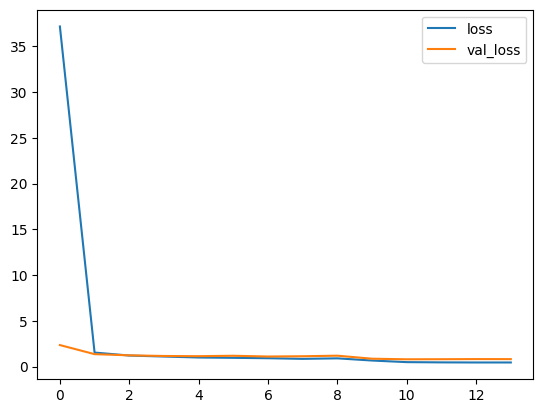

In [60]:
# Plot
plt.plot(loss, label = 'loss')
plt.plot(val_loss, label = 'val_loss')
plt.legend()
plt.show()

In [62]:
# Predictions with test data
predictions_v1 = model_pt_v1.predict(X_test_array)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


In [63]:
# Labels extract
predictions_v1_labels = predictions_v1.argmax(axis = 1)

In [64]:
print(classification_report(y_test_le, predictions_v1_labels))

              precision    recall  f1-score   support

           0       0.83      0.81      0.82       275
           1       0.81      0.82      0.82       224
           2       0.86      0.90      0.88       695
           3       0.67      0.72      0.70       159
           4       0.90      0.85      0.87       581
           5       0.69      0.65      0.67        66

    accuracy                           0.84      2000
   macro avg       0.79      0.79      0.79      2000
weighted avg       0.84      0.84      0.84      2000



In [65]:
print(confusion_matrix(y_test_le, predictions_v1_labels))

[[223   5   7   6  30   4]
 [ 10 184   6   1  11  12]
 [  7   6 625  45  11   1]
 [  6   2  32 114   3   2]
 [ 19  20  50   1 491   0]
 [  5   9   7   2   0  43]]


In [66]:
print(accuracy_score(y_test_le, predictions_v1_labels))

0.84


In [67]:
# Model save
model_pt_v1.save('model_pt_v1.keras') 

### Step 8: Deploy - Model Version 1

In [70]:
# Load model
loaded_model = load_model('model_pt_v1.keras')  

In [71]:
# New phrase (sentiment = fear)
phrase = "i even feel a little shaky"

In [72]:
# Create dataframe with phrase
df_newer = pd.DataFrame({'Phrase': [phrase]})

In [76]:
# Apply Pre Process Function
df_newer['Processed_Phrase'] = df_newer['Phrase'].apply(pt_preprocessing_text)

In [77]:
df_newer

,Phrase,Processed_Phrase
0,i even feel a little shaky,feel little shaky


In [78]:
# Apply vectorization
df_newer_tfidf = pt_tfidf.transform(df_newer['Processed_Phrase'])

In [79]:
# Transform into array
df_newer_array = df_newer_tfidf.toarray()

In [80]:
# Predictions
predictions = loaded_model.predict(df_newer_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


In [81]:
predictions

array([[1.8898817e-06, 9.9735969e-01, 2.6607999e-04, 8.4900403e-06,
        1.1605173e-03, 1.2033631e-03]], dtype=float32)

In [82]:
# Select the class with the highest probability
high_prob_class = np.argmax(predictions, axis = 1)

In [83]:
high_prob_class

array([1])

In [84]:
# Get name of the class
class_name = pt_le.inverse_transform(high_prob_class) # Reverse transforme to get class value

In [85]:
# Predicted class
class_name

array(['fear'], dtype=object)

In [87]:
%watermark -a "postcristiano.pt"

%watermark -v -m

%watermark --iversions

Author: postcristiano.pt

Python implementation: CPython
Python version       : 3.12.8
IPython version      : 8.31.0

Compiler    : Clang 16.0.0 (clang-1600.0.26.4)
OS          : Darwin
Release     : 24.2.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

tqdm        : 4.67.1
pandas      : 2.2.3
spacy       : 3.8.4
matplotlib  : 3.10.0
tensorflow  : 2.18.0
numpy       : 2.0.2
transformers: 4.48.1
nltk        : 3.9.1
tokenizers  : 0.21.0
scipy       : 1.15.1
logging     : 0.5.1.2
keras       : 3.8.0
sklearn     : 1.6.1

